﻿# 保存和加载模型

下面学习如何使用 PyTorch 保存和加载模型。我们经常需要加载之前训练过的模型，或继续用新的数据训练模型。所以这部分还是挺重要的。

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper
import fc_model

In [5]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

下面是一个图像示例。

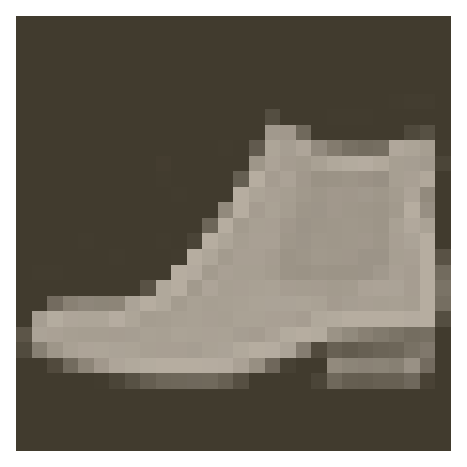

In [6]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);


# 训练网络

我将上一部分的模型架构和训练代码移到了文件 `fc_model` 中。通过导入此模块，我们可以使用 `fc_model.Network` 轻松创建一个完全连接的网络，并使用 `fc_model.train` 训练网络。我会使用经过训练后的模型来演示保存和加载。

In [7]:
# Create the network, define the criterion and optimizer

model = fc_model.Network(784, 10, [512, 256, 128])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
fc_model.train(model, trainloader, testloader, criterion, optimizer, epochs=2)

Epoch: 1/2..  Training Loss: 1.703..  Test Loss: 0.997..  Test Accuracy: 0.659
Epoch: 1/2..  Training Loss: 1.060..  Test Loss: 0.738..  Test Accuracy: 0.733
Epoch: 1/2..  Training Loss: 0.865..  Test Loss: 0.680..  Test Accuracy: 0.742
Epoch: 1/2..  Training Loss: 0.790..  Test Loss: 0.663..  Test Accuracy: 0.757
Epoch: 1/2..  Training Loss: 0.783..  Test Loss: 0.633..  Test Accuracy: 0.762
Epoch: 1/2..  Training Loss: 0.699..  Test Loss: 0.602..  Test Accuracy: 0.772
Epoch: 1/2..  Training Loss: 0.690..  Test Loss: 0.580..  Test Accuracy: 0.789
Epoch: 1/2..  Training Loss: 0.697..  Test Loss: 0.580..  Test Accuracy: 0.784
Epoch: 1/2..  Training Loss: 0.686..  Test Loss: 0.550..  Test Accuracy: 0.796
Epoch: 1/2..  Training Loss: 0.682..  Test Loss: 0.536..  Test Accuracy: 0.802
Epoch: 1/2..  Training Loss: 0.615..  Test Loss: 0.536..  Test Accuracy: 0.798
Epoch: 1/2..  Training Loss: 0.659..  Test Loss: 0.554..  Test Accuracy: 0.800
Epoch: 1/2..  Training Loss: 0.640..  Test Loss: 0.5

## 保存和加载网络

每次需要使用网络时都去训练它不太现实，也很不方便。我们可以保存训练过的网络，之后加载这些网络来继续训练或用它们进行预测。

PyTorch 网络的参数保存在模型的 `state_dict` 中。可以看到这个状态字典包含每个层级的权重和偏差矩阵。

In [9]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


最简单的方法是使用 `torch.save` 保存状态字典。例如，我们可以将其保存到文件 `'checkpoint.pth'` 中。

In [10]:
torch.save(model.state_dict(), 'checkpoint.pth')

然后，使用 `torch.load` 加载这个状态字典。

In [11]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


要将状态字典加载到神经网络中，需要执行 `model.load_state_dict(state_dict)`。

In [12]:
model.load_state_dict(state_dict)

<All keys matched successfully>

看上去很简单？其实不然！只有模型结构和检查点的结构完全一样时，状态字典才能加载成功哦。如果我在创建模型时使用了不同的结构，便无法顺利加载。

In [13]:
# Try this
model = fc_model.Network(784, 10, [400, 200, 100])
# This will throw an error because the tensor sizes are wrong!
model.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for Network:
	size mismatch for hidden_layers.0.weight: copying a param with shape torch.Size([512, 784]) from checkpoint, the shape in current model is torch.Size([400, 784]).
	size mismatch for hidden_layers.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([400]).
	size mismatch for hidden_layers.1.weight: copying a param with shape torch.Size([256, 512]) from checkpoint, the shape in current model is torch.Size([200, 400]).
	size mismatch for hidden_layers.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for hidden_layers.2.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([100, 200]).
	size mismatch for hidden_layers.2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for output.weight: copying a param with shape torch.Size([10, 128]) from checkpoint, the shape in current model is torch.Size([10, 100]).

这就是说，我们需要重新构建和训练时完全一样的模型。我们需要将模型架构信息与状态字典一起保存在检查点里。所以，你需要创建一个字典，其中包含完全重新构建模型所需的所有信息。

In [14]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [each.out_features for each in model.hidden_layers],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

现在，检查点中包含了重建训练模型所需的全部信息。你可以随意将它编写为函数。同样，我们可以编写一个函数来加载检查点。

In [15]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = fc_model.Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

```python
model = load_checkpoint('checkpoint.pth')
print(model)
```